In [2]:
from datasets import load_dataset

dataset_id = "zwhe99/DeepMath-103K"
train_dataset = load_dataset(dataset_id)

c:\Users\axeld\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Filter the dataset to get examples with difficulty < 4
filtered_dataset = train_dataset['train'].filter(lambda x: x['difficulty'] < 4)

print(f"\nFiltered dataset with difficulty < 4:")
print(f"Number of examples: {len(filtered_dataset)}")


Filtered dataset with difficulty < 4:
Number of examples: 4459


In [4]:
# Get all indices and shuffle them
all_indices = list(range(len(filtered_dataset)))
import random
random.seed(42)
random.shuffle(all_indices)

# Split into non-overlapping sets of 200 each
train_indices = all_indices[:200]
rl_indices = all_indices[200:400]
test_indices = all_indices[400:600]

# Create the datasets
train = filtered_dataset.select(train_indices)
rl = filtered_dataset.select(rl_indices)
test = filtered_dataset.select(test_indices)

print("Train set size:", len(train))
print("RL set size:", len(rl))
print("Test set size:", len(test))

# Print example from each set
print("\nExample from train set:")
print("Question:", train[0]["question"])
print("Answer:", train[0]["final_answer"]) 

print("\nExample from RL set:")
print("Question:", rl[0]["question"])
print("Answer:", rl[0]["final_answer"])

print("\nExample from test set:")
print("Question:", test[0]["question"]) 
print("Answer:", test[0]["final_answer"])





Train set size: 200
RL set size: 200
Test set size: 200

Example from train set:
Question: Given the premise \( \neg (A \rightarrow B) \), derive the conclusion \( A \land \neg B \).
Answer: A \land \neg B

Example from RL set:
Question: What is the degree measure of the supplement of the complement of a 42-degree angle?
Answer: 132

Example from test set:
Question: Find the square root of $\dfrac{8!}{70}$.  (Reminder: The number $n!$ is the product of the integers from 1 to $n$.  For example, $5!=5\cdot 4\cdot3\cdot2\cdot 1= 120$.)
Answer: 24


In [11]:
from google import genai
from dotenv import load_dotenv
import os

load_dotenv()

client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))  

20
20
\frac{1
\frac{1}{6}
-2
-2
\frac{7
\dfrac{7}{5k}
35
35
525
525
4
4
1
1
2\sqrt{5
2 \sqrt{5}
648
648
91
91
\begin{pmatrix
\begin{pmatrix} 301 & 100 \\ -900 & -299 \end{pmatrix}
a < b
C
19
19
\frac{3
\frac{3}{5}
86
86
b-a
b - a
21
21
900
900
1
1
(3,-1)
(3,-1)
11
11
-\frac{3
-\dfrac{3}{2}
No boxed text found
0
45
45
26
26
x^2 + 4x + 9
x^2 + 4x + 9
1, 4, -5
-5, 1, 4
\frac{3
\dfrac{3}{4}
Infinity
\infty
2e^3
2e^3
18
18
-\pi \text{ and 
D
8
8
125000
125,\!000
20100
20100
True
True
12
12
126
126
\sqrt{-1
\sqrt{-1} + 2
1
1
8/7
\frac{8}{7}
3
3
50
50
83.5
83.5
17
17
60
60
i
i
3,110,400
3,\!110,\!400
-2
-2
5
5
2, -1/4
2,-\frac{1}{4}
1800
1800
16
16
\frac{9
\dfrac{9}{11}
No
No
0
0
11
11
108
108
1
1
A
\text{(A)}
0.295
\dfrac{59}{200}
2
2
420
420
44
44
2\sqrt{11
2 \sqrt{11}
20
20
2
2
-\frac{4
-\frac{4}{5}
7/13
\dfrac{7}{13}
4
4
\begin{pmatrix
\begin{pmatrix} 11 \\ -13 \\ -1 \end{pmatrix}
353
353
No boxed text found
8x -1
No boxed text found
81
\theta \mathrm{d
\theta \, dR
60
60
5
5
21
21
A
\tex

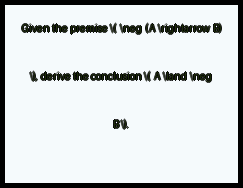

In [12]:
# Generate images for questions in each set
from text_image_generator import save_augmented_text_image
import os
import json
import re

# Create output directories
os.makedirs("train_set/train_images", exist_ok=True)
os.makedirs("train_set/rl_images", exist_ok=True) 
os.makedirs("train_set/eval_images", exist_ok=True)

# Generate images and info for train set
train_info = []
for i, example in enumerate(train):
    if i:
        question = example["question"]
        output_path = f"train_set/train_images/question_{i}.png"
        save_augmented_text_image(question, output_path)
        response = client.models.generate_content(
            model="gemini-2.5-flash-preview-04-17",
            contents=[question]
        )
        # Extract text in \boxed{} from response
        boxed_text = re.findall(r'\\boxed{(.*?)}', response.text)
        if boxed_text:
            print(boxed_text[0])  # Print first boxed answer
        else:
            print("No boxed text found")  # Print full response if no boxed answer found
        print(example["final_answer"])
        train_info.append({
            "ocr": question,
            "image_path": output_path,
            "answer": example["final_answer"],
            "model_response": response.text
        })
with open("train_set/train_info.json", "w") as f:
    json.dump(train_info, f)

# Generate images and info for RL set  
rl_info = []
for i, example in enumerate(rl):
    question = example["question"]
    output_path = f"train_set/rl_images/question_{i}.png"
    save_augmented_text_image(question, output_path)
    rl_info.append({
        "ocr": question,
        "image_path": output_path,
        "answer": example["final_answer"]
    })
with open("train_set/rl_info.json", "w") as f:
    json.dump(rl_info, f)

# Generate images and info for test/eval set
eval_info = []
for i, example in enumerate(test):
    question = example["question"]
    output_path = f"train_set/eval_images/question_{i}.png"
    save_augmented_text_image(question, output_path)
    eval_info.append({
        "ocr": question,
        "image_path": output_path,
        "answer": example["final_answer"]
    })
with open("train_set/eval_info.json", "w") as f:
    json.dump(eval_info, f)

print(f"Generated images and info files for:")
print(f"Train set: {len(train)} images")
print(f"RL set: {len(rl)} images")
print(f"Eval set: {len(test)} images")

# Display first image as example
from IPython.display import Image, display
display(Image("train_set/train_images/question_0.png"))
